In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from vit_keras import vit
import random

c:\Users\bruno\Centennial_College\Deep_Learning\Group_Project\deep_learning\conda-env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\bruno\Centennial_College\Deep_Learning\Group_Project\deep_learning\conda-env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some t

In [2]:
# Set Seed for Reproducibility

tf.random.set_seed(42)
np.random.seed(42)


In [3]:
# Define Constants

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 20


In [4]:
# Load and Prepare the Dataset

data_dir = "data\\brain_tumors\\brain_tumors"
class_names = os.listdir(data_dir)
num_classes = len(class_names)

data = []
labels = []
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        data.append(img_array)
        labels.append(class_names.index(class_name))

data = np.array(data)
labels = np.array(labels)

In [5]:
# Normalize Pixel Values

data = data.astype('float32') / 255.0

In [6]:
# Split Data into Training, Validation, and Testing Sets

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


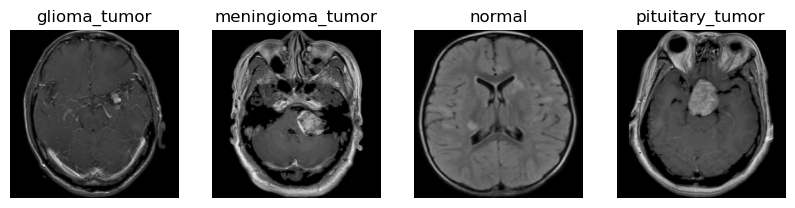

In [7]:
# Plot Sample Images

plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names):
    plt.subplot(1, num_classes, i+1)
    class_dir = os.path.join(data_dir, class_name)
    sample_image_file = random.choice(os.listdir(class_dir))
    sample_image_path = os.path.join(class_dir, sample_image_file)
    img = plt.imread(sample_image_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [8]:
# Display Number of Images per Class

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    print(f"Number of images in {class_name}: {len(os.listdir(class_dir))}")

Number of images in glioma_tumor: 901
Number of images in meningioma_tumor: 913
Number of images in normal: 438
Number of images in pituitary_tumor: 844


In [10]:
# ## Supervised Learning Model - Vision Transformer

In [11]:
# Define the Vision Transformer model using vit_keras library
vit_model = vit.vit_b32(
    image_size=IMG_HEIGHT,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=num_classes
)

c:\Users\bruno\Centennial_College\Deep_Learning\Group_Project\deep_learning\conda-env\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 4, 4
  warnings.warn(


In [12]:
# Build the model architecture including additional layers on top of ViT
model = tf.keras.Sequential([
    vit_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation=tfa.activations.gelu),
    layers.BatchNormalization(),
    layers.Dense(64, activation=tfa.activations.gelu),
    layers.Dense(num_classes, activation='softmax')
], name='vision_transformer')

In [13]:
# Compile the model
model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
# Train the model
history = model.fit(
    x_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(x_val, y_val)
)


Epoch 1/20
62/62 [==============================] - 229s 2s/step - loss: 1.6763 - accuracy: 0.2737 - val_loss: 1.2526 - val_accuracy: 0.4536
Epoch 2/20
62/62 [==============================] - 146s 2s/step - loss: 1.2770 - accuracy: 0.4631 - val_loss: 1.0358 - val_accuracy: 0.5847
Epoch 3/20
62/62 [==============================] - 135s 2s/step - loss: 1.0731 - accuracy: 0.5692 - val_loss: 0.8660 - val_accuracy: 0.6633
Epoch 4/20
62/62 [==============================] - 135s 2s/step - loss: 0.8778 - accuracy: 0.6485 - val_loss: 0.7416 - val_accuracy: 0.7157
Epoch 5/20
62/62 [==============================] - 138s 2s/step - loss: 0.7694 - accuracy: 0.7030 - val_loss: 0.6615 - val_accuracy: 0.7560
Epoch 6/20
62/62 [==============================] - 132s 2s/step - loss: 0.6488 - accuracy: 0.7717 - val_loss: 0.6060 - val_accuracy: 0.7823
Epoch 7/20
62/62 [==============================] - 129s 2s/step - loss: 0.5783 - accuracy: 0.8035 - val_loss: 0.5642 - val_accuracy: 0.7923
Epoch 8/20
62

In [15]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

20/20 [==============================] - 12s 581ms/step - loss: 0.3745 - accuracy: 0.8855
Test accuracy: 0.8854838609695435


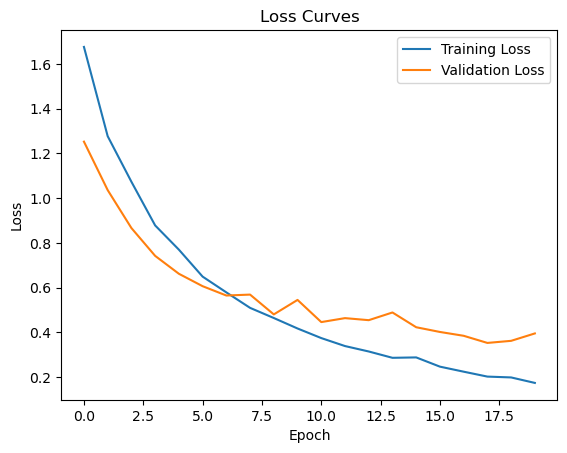

In [16]:
# Display Training and Validation Loss Curves
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# ## Unsupervised Learning Model - Generative Adversarial Network (GAN)


In [18]:
# Define the generator model
def get_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(16 * 16 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((16, 16, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [19]:
# Define the discriminator model
def get_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [20]:
# Instantiate and compile the GAN components
generator = get_generator(100)
discriminator = get_discriminator()

In [21]:
# Combine GAN into a single model
gan = tf.keras.Sequential([generator, discriminator])
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [22]:
# ## Training the GAN

In [29]:
# Define the GAN training function
def train_gan(gan, generator, discriminator, dataset, latent_dim, epochs=50, batch_size=128, save_interval=10):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        for batch in range(dataset.shape[0] // batch_size):
            # Train Discriminator
            idx = np.random.randint(0, dataset.shape[0], half_batch)
            real_imgs = dataset[idx]
            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            fake_imgs = generator.predict(noise)
            
            real_y = np.ones((half_batch, 1))
            fake_y = np.zeros((half_batch, 1))
            
            d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
            d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_y = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(noise, valid_y)

            # Progress logging
            print(f"{epoch + 1}/{epochs}, {batch + 1}/{dataset.shape[0] // batch_size}, D Loss: {d_loss}, G Loss: {g_loss}")
        
        # Save generated images
        if (epoch + 1) % save_interval == 0:
            save_images(epoch, generator, latent_dim)


In [30]:
# Helper function to save generated images
def save_images(epoch, generator, latent_dim, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch + 1}.png')
    plt.close()

In [31]:
# Prepare the GAN components and dataset
latent_dim = 100
generator = get_generator(latent_dim)
discriminator = get_discriminator()
gan = models.Sequential([generator, discriminator])
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan_dataset = (x_train * 2) - 1

In [32]:
# Start the GAN training process
train_gan(gan, generator, discriminator, gan_dataset, 100, epochs=50, batch_size=32)

1/1 [==============================] - 0s 113ms/step
1/50, 1/61, D Loss: 4.066186923533678, G Loss: 0.0
1/1 [==============================] - 0s 41ms/step
1/50, 2/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 39ms/step
1/50, 3/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 48ms/step
1/50, 4/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 40ms/step
1/50, 5/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 44ms/step
1/50, 6/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 47ms/step
1/50, 7/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 46ms/step
1/50, 8/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 41ms/step
1/50, 9/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 43ms/step
1/50, 10/61, D Loss: 0.0, G Loss: 0.0
1/1 [==============================] - 0s 40ms/step
1/50, 11/61, D Loss: 0.0, G Loss: 0.0
1/1 

In [33]:
# ## Evaluate the Generator Model

In [34]:
# Generate images for evaluation
def generate_and_save_images(model, num_examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (num_examples, 100))
    predictions = model.predict(noise)
    predictions = (predictions + 1) / 2.0  # Rescale to [0,1]

    plt.figure(figsize=figsize)
    for i in range(num_examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 104ms/step


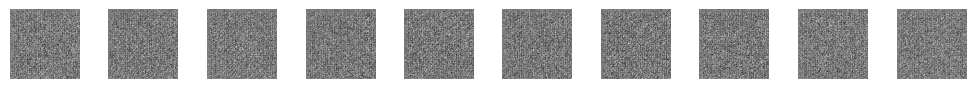

In [35]:
generate_and_save_images(generator)


In [36]:
# ## Save the Models
generator.save('generator_final.h5')
discriminator.save('discriminator_final.h5')